In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# source: https://gist.github.com/rozanecm/38f2901c592bdffc40726cb0473318cf
# Function which plays a beep of given duration and frequency.
# Useful for when executing things that need a while to finish, to get notified.
import os
def beep(duration = 1, freq = 1500):
    """ play tone of duration in seconds and freq in Hz. """
    os.system('play --no-show-progress --null --channels 1 synth %s sine %f' % (duration, freq))

In [3]:
# This will allow you to see all column names & rows when you are doing .head(). None of the column name will be truncated.
# source: https://stackoverflow.com/questions/49188960/how-to-show-all-of-columns-name-on-pandas-dataframe

pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 140)

In [4]:
df = pd.read_csv('../data/train.csv', dtype={'tipodepropiedad':'category', 'ciudad':'category', 'provincia':'category', 'id':'int32', 'antiguedad':'float16', 'habitaciones':'float16', 'garages':'float16', 'banos':'float16', 'metroscubiertos':'float16', 'metrostotales':'float16', 'idzona':'float16', 'lat':'float16', 'lng':'float16', 'gimnasio':'bool', 'usosmultiples':'bool', 'piscina':'bool', 'escuelascercanas':'bool', 'centroscomercialescercanos':'bool'}, parse_dates=['fecha'])

In [5]:
precios_dolares = pd.read_csv('../data/precios_en_dolares.csv')

In [6]:
df = df.merge(precios_dolares, how='left')

In [7]:
del precios_dolares

# Plotting functions

In [8]:
def named_series_plot(named_series, title='', xlabel='', ylabel='', xlabel_fontsize=14, ylabel_fontsize=14, xticks_fontsize=None, title_fontsize=20, xticks_rotation=45, save_fig=False, filename='default_filename'):
    plt.figure(figsize=(12,6))
    bar_names = list(named_series.index)

    plt.bar(bar_names, named_series, width=0.5, log=False)

    plt.xlabel(xlabel, fontsize=14)
    plt.ylabel(ylabel, fontsize=14)
    
    plt.xticks(rotation=xticks_rotation, fontsize=xticks_fontsize)

    plt.title(title, fontsize=20);
    
    if save_fig:
        filename = filename + '.png'
        plt.savefig(filename)

In [9]:
def histogram_plot(df, column, bins=None, title='', xlabel='', ylabel='', xlabel_fontsize=14, ylabel_fontsize=14, title_fontsize=20, xticks_rotation=0, save_fig=False, filename='default_filename'):
    plt.figure(figsize=(12,6))

    plt.hist(df[column], density=True)
    plt.xlabel(xlabel, fontsize=xlabel_fontsize)
    plt.ylabel(ylabel, fontsize=ylabel_fontsize)
    
    plt.xticks(rotation=xticks_rotation)

    plt.title(title, fontsize=title_fontsize);
    
    if save_fig:
        filename = filename + '.png'
        plt.savefig(filename)

In [10]:
def density_plot(df, column, title='', xlabel='', ylabel='', xlabel_fontsize=14, ylabel_fontsize=14, title_fontsize=20, xticks_rotation=0, save_fig=False, filename='default_filename', dropna=True, log=False, bins=None, hist=True, kde=True, rug=False, fit=None, hist_kws=None, kde_kws=None, rug_kws=None, fit_kws=None, color=None, vertical=False, norm_hist=False, axlabel=None, label=None, ax=None):
    """
    This function uses seaborn's distplot to plot the distribution of a variable.
    The arguments received are passed directly to the seaborn function,
    so to see the meaning of any of them, please refer to the seaborn documentation.
    """
    import seaborn as sns
    plt.figure(figsize=(12,6))

    if dropna:
        data = df[column].dropna()
    else:
        data = df[column]
    
    ax = sns.distplot(data, bins, hist, kde, rug, fit, hist_kws, kde_kws, rug_kws, fit_kws, color, vertical, norm_hist, axlabel, label, ax)
    
    if log:
        ax.set_xscale('log')
    plt.xlabel(xlabel, fontsize=xlabel_fontsize)
    plt.ylabel(ylabel, fontsize=ylabel_fontsize)
    
    plt.xticks(rotation=xticks_rotation)

    plt.title(title, fontsize=title_fontsize);
    
    if save_fig:
        filename = filename + '.png'
        plt.savefig(filename)

# Análisis

In [29]:
print(df.shape)

(240000, 23)


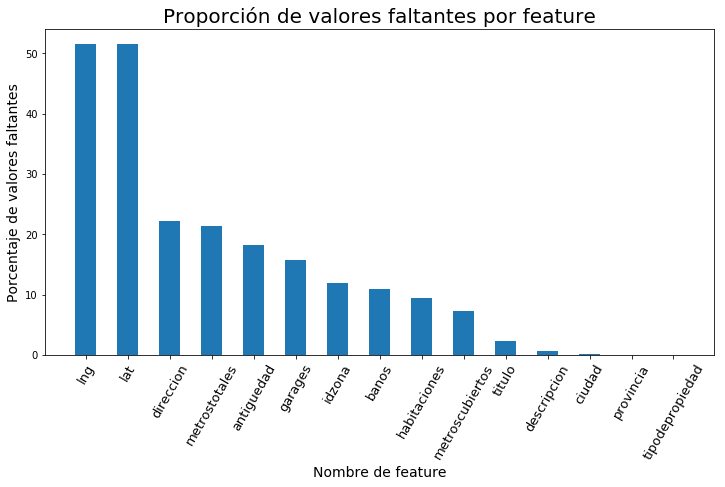

In [47]:
missing = df.isnull().sum()
missing = (missing/df.shape[0])*100
missing = missing[missing > 0]
missing.sort_values(inplace=True, ascending=False)
named_series_plot(missing, title='Proporción de valores faltantes por feature', xlabel='Nombre de feature', ylabel='Porcentaje de valores faltantes', xticks_fontsize=13, xticks_rotation=60, save_fig=True, filename='missing_values')

Qué significa lat. y lon.? Son datos reales?

In [50]:
df[['lat','lng','ciudad']].head(10)

,lat,lng,ciudad
0,NaN,NaN,Benito Juárez
1,19.312500,-99.2500,La Magdalena Contreras
2,NaN,NaN,Tonalá
3,19.296875,-99.6875,Zinacantepec
4,NaN,NaN,Zapopan
5,19.296875,-99.1250,Coyoacán
6,17.140625,-96.8125,Oaxaca de Juárez
7,20.671875,-87.0625,Playa del Carmen
8,NaN,NaN,Villa de Alvarez
9,19.312500,-98.8750,Ixtapaluca


Verificando a mano en Google Maps, las coordenadas de los siguientes registros pertenecen a la ciudad indicada en el mismo registro, por lo que suponemos que las coordenadas de todos los datos son reales.
```
  1 |-----------+----------+------------------------+---------------------------|   
  2 | lat       | long     | ciudad                 | exactitud                 |   
  3 |-----------+----------+------------------------+---------------------------|   
  4 | 19.312500 | -99.2500 | La Magdalena Contreras | exacto                    |   
  5 | 19.296875 | -99.6875 | Zinacantepec           | muy cerca (alguna cuadra) |   
  6 | 19.296875 | -99.1250 | Coyoacán               | muy cerca (alguna cuadra) |   
  7 |-----------+----------+------------------------+---------------------------|
```

In [57]:
print(df.loc[df['lat'].isna()]['lng'].shape[0])
print(df.loc[df['lat'].isna()]['lng'].isna().sum())

123488
123488


In [63]:
print(df.loc[df['lat'].isna()]['direccion'].shape[0])
print(df.loc[df['lat'].isna()]['direccion'].isna().sum())
print(df.loc[df['lat'].isna() & df['direccion'].isna()]['ciudad'].isna().sum())
print(df.loc[df['lat'].isna() & df['direccion'].isna() & df['ciudad'].isna()]['provincia'].isna().sum())

123488
28298
111
83


In [58]:
df.columns

Index(['id', 'titulo', 'descripcion', 'tipodepropiedad', 'direccion', 'ciudad',
       'provincia', 'antiguedad', 'habitaciones', 'garages', 'banos',
       'metroscubiertos', 'metrostotales', 'idzona', 'lat', 'lng', 'fecha',
       'gimnasio', 'usosmultiples', 'piscina', 'escuelascercanas',
       'centroscomercialescercanos', 'precio'],
      dtype='object')

## Completando lats y longs
***
**NOTA** Todo esto se proceso en Kaggle. **No correr esta parte aca***.

In [154]:
from  geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter

def completar_coord(df, coord_a_completar):
    """coord_a_completar: string: 'lat', 'lon'"""
    geolocator = Nominatim(user_agent='my-proj')
    
    geocode = RateLimiter(geolocator.geocode, min_delay_seconds=0.0, max_retries=10)
    
    direction = df['direccion']
    city = df['ciudad']
    province = df['provincia']
    country = "Mexico"
    
    query = ""
    if not pd.isnull(direction):
        query += direction + ','
    if not pd.isnull(city):
        query += city + ','
    if not pd.isnull(province):
        query += province + ','
        
    query += country
    
    print('doing query: ', query)
    
    loc = geocode(query)
    
    if loc:
        if coord_a_completar == 'lat':
            return loc.latitude
        if coord_a_completar == 'lat':
            return loc.latitude
#     x.lng = loc.longitude

In [149]:
df.loc[df['lat'].isna()][['direccion','ciudad','provincia']].head(10)

,direccion,ciudad,provincia
0,Avenida Division del Norte 2005,Benito Juárez,Distrito Federal
2,Urbi Tonala,Tonalá,Jalisco
4,PASEOS DEL SOL,Zapopan,Jalisco
8,BUENAVISTA DEPTOS CON SUBSIDIO,Villa de Alvarez,Colima
11,NaN,San Pedro Garza García,Nuevo León
17,Pazaje Santa Cruz,Benito Juárez,Distrito Federal
18,Milenio,Querétaro,Querétaro
19,SENDA CELESTIAL 10,Querétaro,Querétaro
20,TERRENO RESIDENCIAL EN VENTA EN CUMBRES,Monterrey,Nuevo León
21,NaN,Querétaro,Querétaro


In [119]:
for e in df.loc[df['lat'].isna()]['direccion'].head():
    print(e)

Avenida Division del Norte 2005
Urbi Tonala
PASEOS DEL SOL 
BUENAVISTA DEPTOS CON SUBSIDIO
nan


In [156]:
# el siguiente codigo es ejecutado en kaggle por temas de performance
# df['lat'] = df.apply(lambda row: completar_coord(row, 'lat') if np.isnan(row['lat']) else row['lat'], axis=1)

In [ ]:
beep()

In [89]:
df.loc[df['lat'].isna()].loc[~df['direccion'].isna() & ~df['ciudad'].isna()][['lat','lng','direccion','ciudad']]

,lat,lng,direccion,ciudad
0,NaN,NaN,Avenida Division del Norte 2005,Benito Juárez
2,NaN,NaN,Urbi Tonala,Tonalá
4,NaN,NaN,PASEOS DEL SOL,Zapopan
8,NaN,NaN,BUENAVISTA DEPTOS CON SUBSIDIO,Villa de Alvarez
17,NaN,NaN,Pazaje Santa Cruz,Benito Juárez
18,NaN,NaN,Milenio,Querétaro
19,NaN,NaN,SENDA CELESTIAL 10,Querétaro
20,NaN,NaN,TERRENO RESIDENCIAL EN VENTA EN CUMBRES,Monterrey
25,NaN,NaN,Lopez Velarde,Apodaca
26,NaN,NaN,MISIONES DE SAN FRANCISCO,Puebla


In [71]:
from  geopy.geocoders import Nominatim
geolocator = Nominatim()
direction = 'Avenida Division del Norte 2005'
city ="Benito Juárez"
country ="Mexico"
loc = geolocator.geocode(direction + ',' + city + ',' + country)
print("latitude is :-" ,loc.latitude,"\nlongtitude is:-" ,loc.longitude)

/home/rozanecm/Documents/Univerza/UBA/7506 Organizacion de Datos/2c2019/tp1/venv/lib/python3.5/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Using Nominatim with the default "geopy/1.20.0" `user_agent` is strongly discouraged, as it violates Nominatim's ToS https://operations.osmfoundation.org/policies/nominatim/ and may possibly cause 403 and 429 HTTP errors. Please specify a custom `user_agent` with `Nominatim(user_agent="my-application")` or by overriding the default `user_agent`: `geopy.geocoders.options.default_user_agent = "my-application"`. In geopy 2.0 this will become an exception.
  


latitude is :- 19.3742354 
longtitude is:- -99.1578917


***
**NOTA IMPORTANTE**
Todo este procesamiento de coords. faltantes se trasladó a Kaggle.
***

# Variable objetivo: Precio

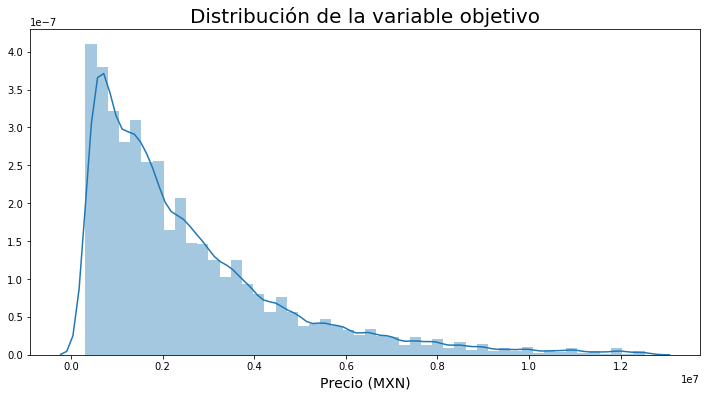

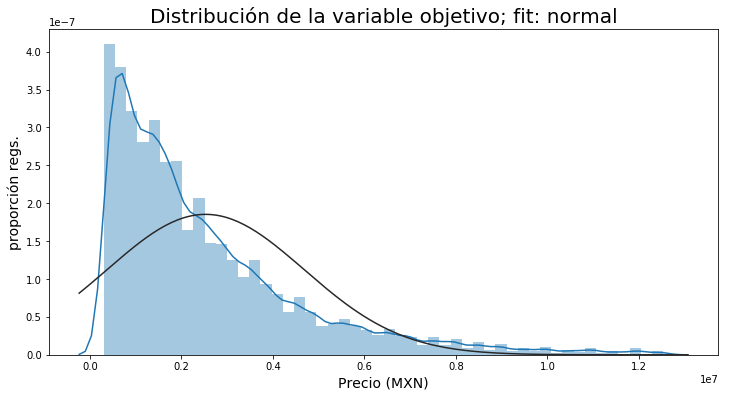

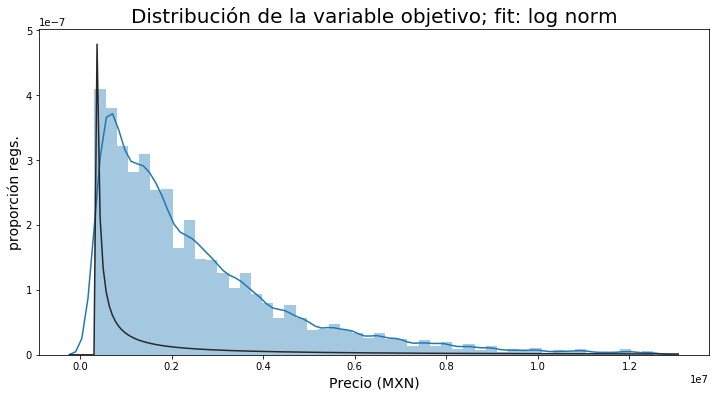

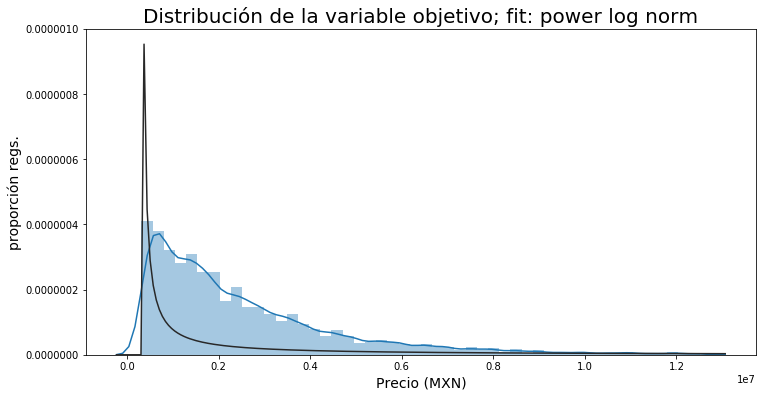

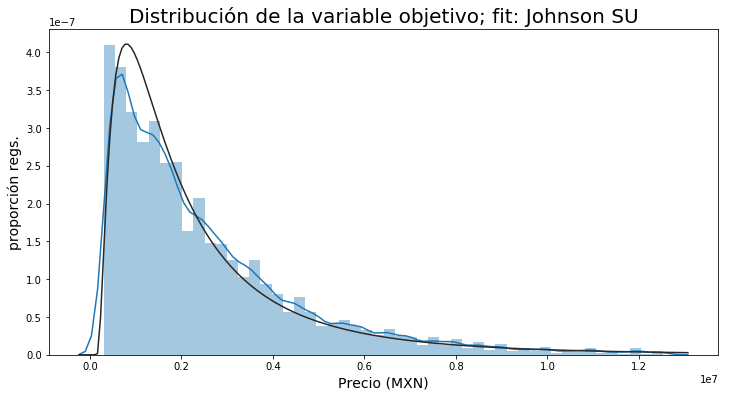

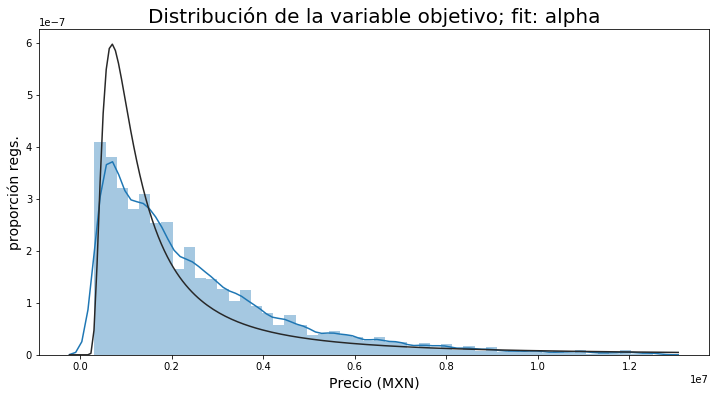

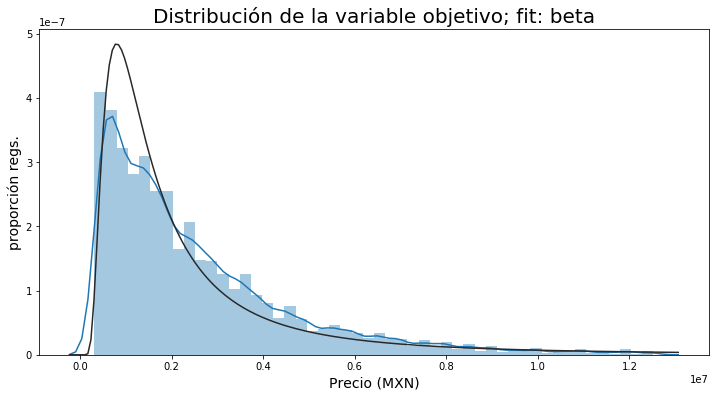

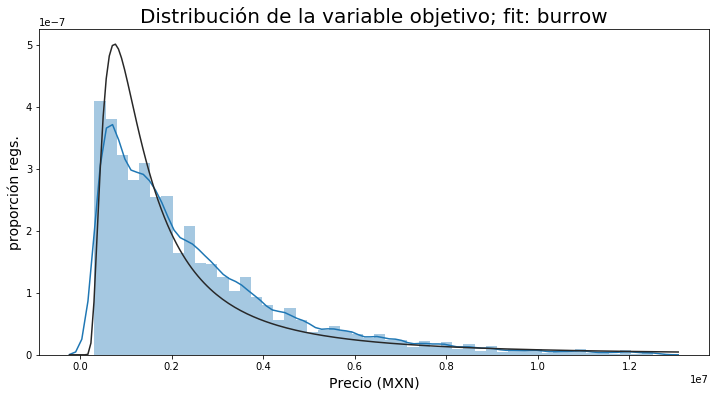

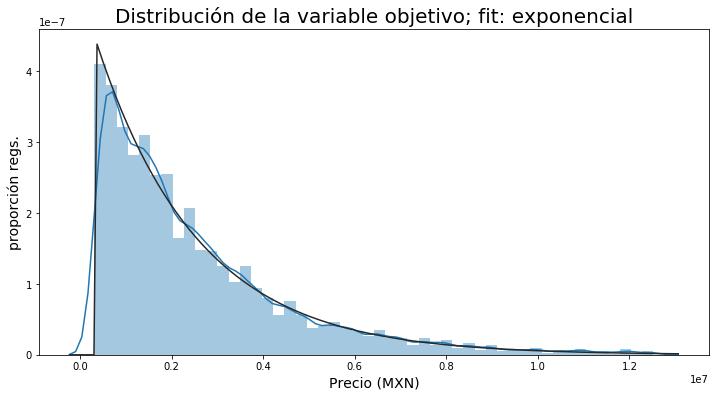

In [15]:
import scipy.stats as st
density_plot(df, 'precio', title='Distribución de la variable objetivo', xlabel='Precio (MXN)')
density_plot(df, 'precio', title='Distribución de la variable objetivo; fit: normal', fit=st.norm, xlabel='Precio (MXN)', ylabel='proporción regs.')
density_plot(df, 'precio', title='Distribución de la variable objetivo; fit: log norm', fit=st.lognorm, xlabel='Precio (MXN)', ylabel='proporción regs.')

density_plot(df, 'precio', title='Distribución de la variable objetivo; fit: power log norm', fit=st.powerlognorm, xlabel='Precio (MXN)', ylabel='proporción regs.')

density_plot(df, 'precio', title='Distribución de la variable objetivo; fit: Johnson SU', fit=st.johnsonsu, xlabel='Precio (MXN)', ylabel='proporción regs.')

density_plot(df, 'precio', title='Distribución de la variable objetivo; fit: alpha', fit=st.alpha, xlabel='Precio (MXN)', ylabel='proporción regs.')

density_plot(df, 'precio', title='Distribución de la variable objetivo; fit: beta', fit=st.betaprime, xlabel='Precio (MXN)', ylabel='proporción regs.')

density_plot(df, 'precio', title='Distribución de la variable objetivo; fit: burrow', fit=st.burr, xlabel='Precio (MXN)', ylabel='proporción regs.')

density_plot(df, 'precio', title='Distribución de la variable objetivo; fit: exponencial', fit=st.expon, xlabel='Precio (MXN)', ylabel='proporción regs.')

Veamos los precios en dolares

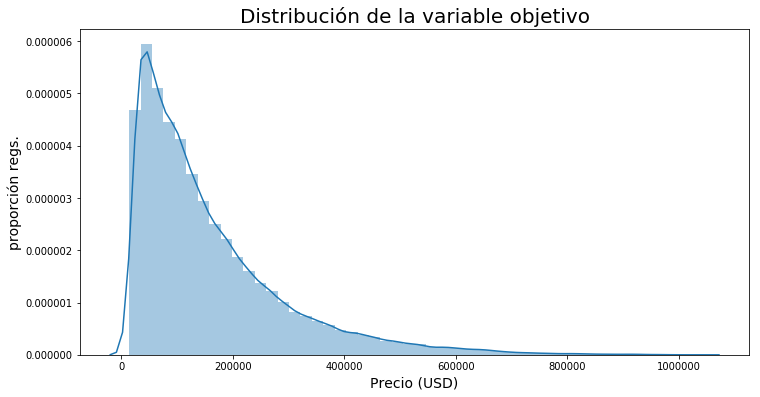

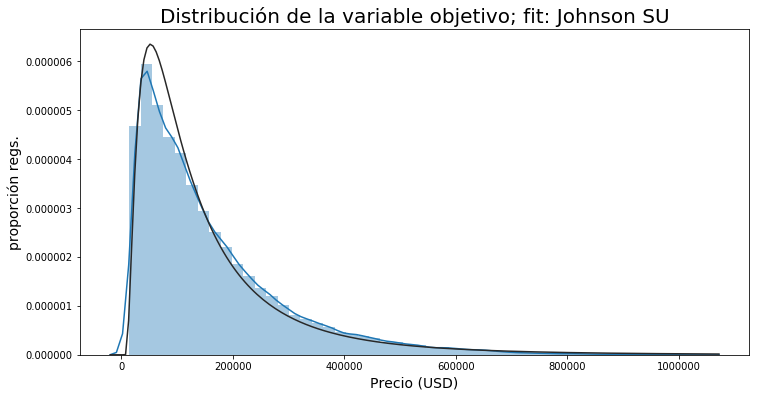

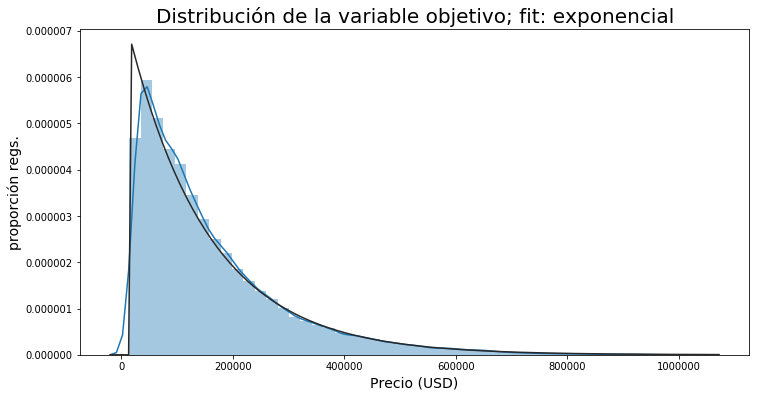

In [16]:
import scipy.stats as st
density_plot(df, 'precio_usd', title='Distribución de la variable objetivo', xlabel='Precio (USD)', ylabel='proporción regs.')
# density_plot(df, 'precio_usd', title='Distribución de la variable objetivo; fit: normal', fit=st.norm)
# density_plot(df, 'precio_usd', title='Distribución de la variable objetivo; fit: log norm', fit=st.lognorm)

# density_plot(df, 'precio_usd', title='Distribución de la variable objetivo; fit: power log norm', fit=st.powerlognorm)

density_plot(df, 'precio_usd', title='Distribución de la variable objetivo; fit: Johnson SU', fit=st.johnsonsu, xlabel='Precio (USD)', ylabel='proporción regs.')

# density_plot(df, 'precio_usd', title='Distribución de la variable objetivo; fit: alpha', fit=st.alpha)

# density_plot(df, 'precio_usd', title='Distribución de la variable objetivo; fit: beta', fit=st.betaprime)

# density_plot(df, 'precio_usd', title='Distribución de la variable objetivo; fit: burrow', fit=st.burr)

density_plot(df, 'precio_usd', title='Distribución de la variable objetivo; fit: exponencial', fit=st.expon, xlabel='Precio (USD)', ylabel='proporción regs.')

Como era de esperar, se puede observar el fenómeno de la cola larga. Indagando un poco más se puede ver que tiene una distribución exponencial.

Veamos la cantidad de propiedades que hay a través del tiempo.

In [36]:
def extract_anio_mes(x):
    if x.month > 9:
        return str(x.year) + " " + str(x.month)
    return str(x.year) + " 0" + str(x.month)

In [37]:
df['anio_mes'] = df['fecha'].apply(lambda x: extract_anio_mes(x))

In [38]:
df['anio_mes'].head()

0    2015 08
1    2013 06
2    2015 10
3    2012 03
4    2016 06
Name: anio_mes, dtype: object

Text(0, 0.5, 'Cant. regs.')

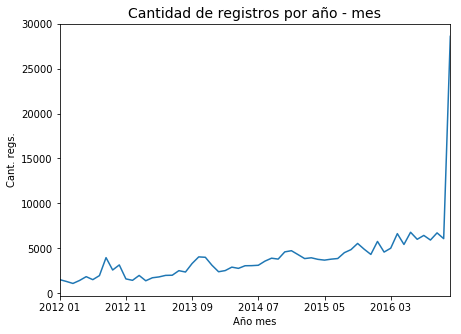

In [51]:
ax = df.groupby('anio_mes').size().sort_index().plot(figsize=(7,5), title='asdf')
ax.set_title('Cantidad de registros por año - mes', fontdict={'fontsize':14})
ax.set_xlabel('Año mes')
ax.set_ylabel('Cant. regs.')

Text(0, 0.5, 'Cant. regs.')

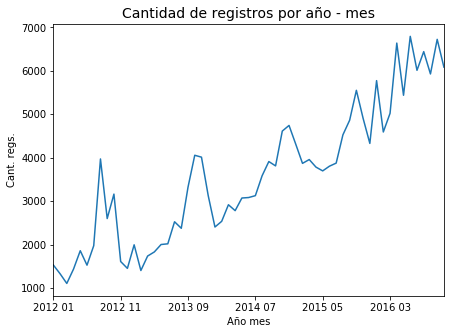

In [55]:
ax = df.loc[~(df['anio_mes'] == '2016 12')].groupby('anio_mes').size().sort_index().plot(figsize=(7,5), title='asdf')
ax.set_title('Cantidad de registros por año - mes', fontdict={'fontsize':14})
ax.set_xlabel('Año mes')
ax.set_ylabel('Cant. regs.')

Text(0, 0.5, 'Cant. regs.')

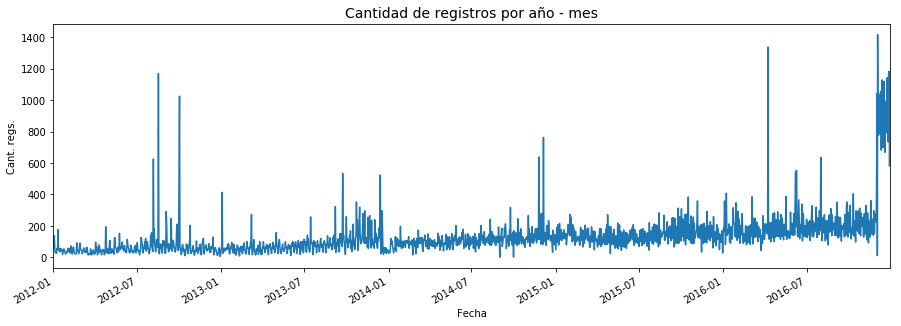

In [59]:
ax = df.groupby('fecha').size().sort_index().plot(figsize=(15,5), title='asdf')
ax.set_title('Cantidad de registros por año - mes', fontdict={'fontsize':14})
ax.set_xlabel('Fecha')
ax.set_ylabel('Cant. regs.')

Text(0, 0.5, 'Precio promedio (usd)')

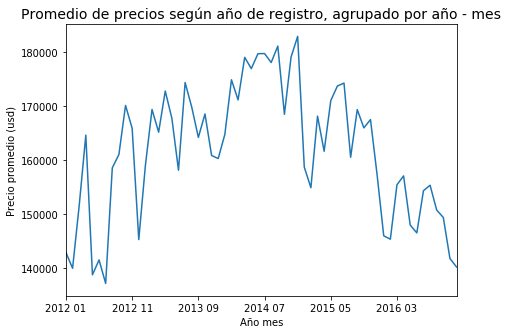

In [70]:
ax = df.groupby('anio_mes')['precio_usd'].mean().sort_index().plot(figsize=(7,5), title='asdf')
ax.set_title('Promedio de precios según año de registro, agrupado por año - mes', fontdict={'fontsize':14})
ax.set_xlabel('Año mes')
ax.set_ylabel('Precio promedio (usd)')

Text(0, 0.5, 'Precio promedio (usd)')

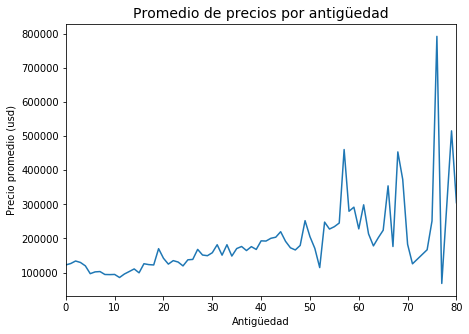

In [76]:
ax = df.groupby('antiguedad')['precio_usd'].median().sort_index().plot(figsize=(7,5), title='asdf')
ax.set_title('Promedio de precios por antigüedad', fontdict={'fontsize':14})
ax.set_xlabel('Antigüedad')
ax.set_ylabel('Precio promedio (usd)')

Text(0, 0.5, 'Precio promedio (usd)')

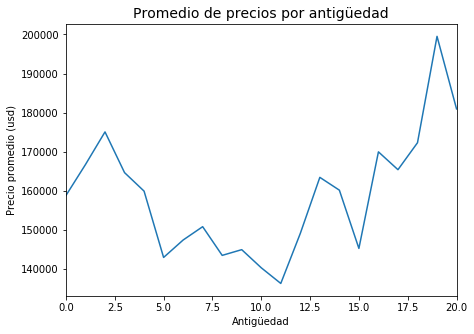

In [75]:
ax = df.loc[df['antiguedad'] < 21].groupby('antiguedad')['precio_usd'].mean().sort_index().plot(figsize=(7,5), title='asdf')
ax.set_title('Promedio de precios por antigüedad', fontdict={'fontsize':14})
ax.set_xlabel('Antigüedad')
ax.set_ylabel('Precio promedio (usd)')

In [27]:
beep()

# Columnas de texto
## Titulo

In [5]:
df['titulo'].value_counts()

casa en venta                                                                                 468
departamento en venta                                                                         289
casa en venta en chihuahua                                                                    268
casa en venta en querétaro                                                                    238
departamento en venta en benito juárez                                                        221
departamento en venta en miguel hidalgo                                                       177
casa en venta en mérida                                                                       167
casa en venta                                                                                 132
casa en venta en torreón                                                                      119
casa en venta en mérida, yucatán                                                              115
casa en venta en mon

In [6]:
df.loc[df['titulo'].fillna('vacio').apply(lambda x: 'venta' in x)].shape[0]/df.shape[0]

0.4531625

El 45% de las propiedades incluyen en su titulo la información de que se trata de una venta.

In [7]:
print(df.loc[df['titulo'].fillna('vacio').apply(lambda x: 'renta' in x or 'alquiler' in x)].shape[0]/df.shape[0])
print(df.loc[df['titulo'].fillna('vacio').apply(lambda x: 'renta' in x or 'alquiler' in x)].shape[0])

0.008379166666666667
2011


El 0.8% habla de renta o alquiler, lo que equivale a 2011 titulos.

In [8]:
print(df.loc[df['titulo'].fillna('vacio').apply(lambda x: 'venta' in x and 'renta' in x)].shape[0]/df.shape[0])

print(df.loc[df['titulo'].fillna('vacio').apply(lambda x: 'venta' in x and 'renta' in x)][['titulo']].shape[0])

0.005804166666666667
1393


In [9]:
print(df.loc[df['titulo'].fillna('vacio').apply(lambda x: 'venta' in x and 'alquiler' in x)].shape[0]/df.shape[0])

print(df.loc[df['titulo'].fillna('vacio').apply(lambda x: 'venta' in x and 'alquiler' in x)][['titulo']].shape[0])

0.0
0


El 0.5% (1393 registros) habla de venta/alquiler de propiedades.

Comparemos con el tipo de propiedad. Se podra sacar alguna info extra del titulo que no este ya en tipo de propiedad?

In [9]:
list(df['tipodepropiedad'].unique())

['Apartamento',
 'Casa en condominio',
 'Casa',
 'Terreno',
 'Terreno comercial',
 'Local Comercial',
 'Quinta Vacacional',
 'Oficina comercial',
 'Edificio',
 'Casa uso de suelo',
 'Local en centro comercial',
 'Bodega comercial',
 'Otros',
 'Villa',
 'Duplex',
 'Inmuebles productivos urbanos',
 'Departamento Compartido',
 'Nave industrial',
 'Rancho',
 'Terreno industrial',
 nan,
 'Huerta',
 'Lote',
 'Hospedaje',
 'Garage']

In [10]:
df['tipodepropiedad'].value_counts()

Casa                             141717
Apartamento                       57341
Casa en condominio                19297
Terreno                            9945
Local Comercial                    3055
Oficina comercial                  1741
Bodega comercial                   1406
Edificio                           1396
Terreno comercial                  1326
Casa uso de suelo                   708
Quinta Vacacional                   395
Duplex                              343
Villa                               340
Inmuebles productivos urbanos       200
Rancho                              170
Local en centro comercial           165
Departamento Compartido             141
Otros                               134
Nave industrial                      76
Terreno industrial                   31
Huerta                               20
Lote                                  5
Hospedaje                             1
Garage                                1
Name: tipodepropiedad, dtype: int64

In [11]:
print('Cantidad de nulos')
print(df['tipodepropiedad'].isna().sum())
print(round(df['tipodepropiedad'].isna().sum()/df.shape[0] * 100, 2), " %")

Cantidad de nulos
46
0.02  %


## Descripcion

In [12]:
print(df['descripcion'].nunique())
print((df['descripcion'].nunique() + df['descripcion'].isna().sum())/df.shape[0])
print(df.shape[0] - (df['descripcion'].nunique() + df['descripcion'].isna().sum()))

232187
0.9741916666666667
6194


In [13]:
# pd.set_option('display.max_colwidth', 250)
df[['descripcion']].head(30)

,descripcion
0,"depto. interior de 80.15m2, consta de sala comedor cocina equipada, área de lavado, baño completo, recamara principal con closet y baño ..."
1,"<p>entre sonora y guerrero, atr&aacute;s del hospital &aacute;ngeles del pedregal, en excelente estado de conservaci&oacute;n, construid..."
2,"descripcion \nla mejor ubicacion residencial en el oriente de la ciudad urbi versalles, te invito a compartir una nueva forma de vida en..."
3,"casa en privada con caseta de vigilancia casas de dos y tres recamaras, a dies minutos del centro de toluca a un costado del valle de za..."
4,bonito departamento en excelentes condiciones muy buena ubicacion listo para habitar llamenos !!!!! y
5,"amplio departamento, estancia de sala y comedor con pared de granito de mármol, dos recamaras con closet, cocina integral, un baño, piso..."
6,"ubicada en esquina, pertenece san lorenzo agencia santiago etla.\ncuenta con:\ntres recamaras\n2 baños completos\nsala\ncomedor- cocina\..."
7,"casa emilia en venta playa del carmenfraccionamiento selvamar, con bicisendas, canchas de tenis con cesped, cenote, solarium con jacuzzi..."
8,"<p>pre-venta de preciosos departamento ecologicos &nbsp;se ejerce con subsidio de 62,000; sala, comedor, cocina con &nbsp;tarja &nbsp;y ..."
9,"terreno de 5.500m2 bardeado, uso de suelo h-200-a, plano de forma irregular colinda al norte con circuito exterior mexiquense con 122m2,..."


(Pasar a issues)
- Se podra hacer algun resumen automatico que represente mas facil la informacion? 
- clustering basado en la descripcion
- wordcloud


# Localizacion
## Direccion

In [14]:
df['direccion'].head(30)

0                    Avenida Division del Norte 2005
1                                         AV. MEXICO
2                                        Urbi Tonala
3                      IGNACIO MANUEL ALTAMIRANO 128
4                                    PASEOS DEL SOL 
5                              Condominio Tlalpan 2B
6                                                NaN
7                               condominio el trebol
8                     BUENAVISTA DEPTOS CON SUBSIDIO
9                                        Av. Morelos
10                                     MI 2° CREDITO
11                                               NaN
12                          Pitahayas 2 - 58, Zibata
13                  MATIAS ROMERO, COLONIA DEL VALLE
14                                               NaN
15                                               NaN
16    CUMBRES DEL LAGO JURIQUILLA, QUERETARO, MEXICO
17                                 Pazaje Santa Cruz
18                                           M

In [15]:
palabras_avenida = ['avenida', 'av']
df['es_avenida'] = df['direccion'].fillna('no info').apply(lambda x: any(avenida_indicator in x.lower() for avenida_indicator in palabras_avenida))

In [16]:
df[['es_avenida','direccion']]

,es_avenida,direccion
0,True,Avenida Division del Norte 2005
1,True,AV. MEXICO
2,False,Urbi Tonala
3,False,IGNACIO MANUEL ALTAMIRANO 128
4,False,PASEOS DEL SOL
5,False,Condominio Tlalpan 2B
6,False,NaN
7,False,condominio el trebol
8,True,BUENAVISTA DEPTOS CON SUBSIDIO
9,True,Av. Morelos


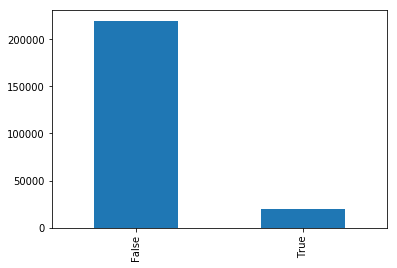

In [17]:
df['es_avenida'].value_counts().plot(kind='bar');

In [18]:
df[['es_avenida','precio']].corr()

,es_avenida,precio
es_avenida,1.000000,0.013038
precio,0.013038,1.000000


Agregar a issues

- Cuando procesemos el precio y saquemos el precio por m2, probablemente valga la pena volver a calcular la corr.

In [19]:
print(df['direccion'].nunique())
print((df['direccion'].nunique()) / df['direccion'].count())
print((df['direccion'].nunique() + df['direccion'].isna().sum()) / df.shape[0])

140269
0.7503905246939998
0.8055875


## Ciudad

In [20]:
df['ciudad'].nunique()

875

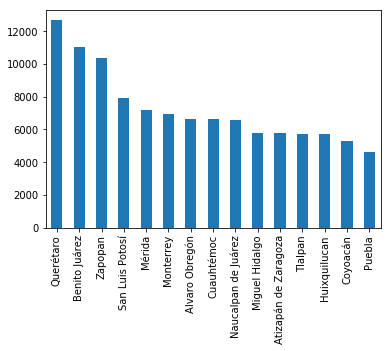

In [21]:
df['ciudad'].value_counts()[:15].plot(kind='bar')

Issues
- hacer boxplot de precio por ciudad para las que tienen mas registros y/o para las de precios mas caros
- ubicar las ciudades en un mapa y mostrar precio con colores

El resto de las columnas de locacion se pueden analizar, pero en principio no creo que aporten mucho.

# Cualidad
## Tipo de propiedad

In [22]:
print(df['tipodepropiedad'].nunique())
print(df['tipodepropiedad'].count()/df.shape[0])

24
0.9998083333333333


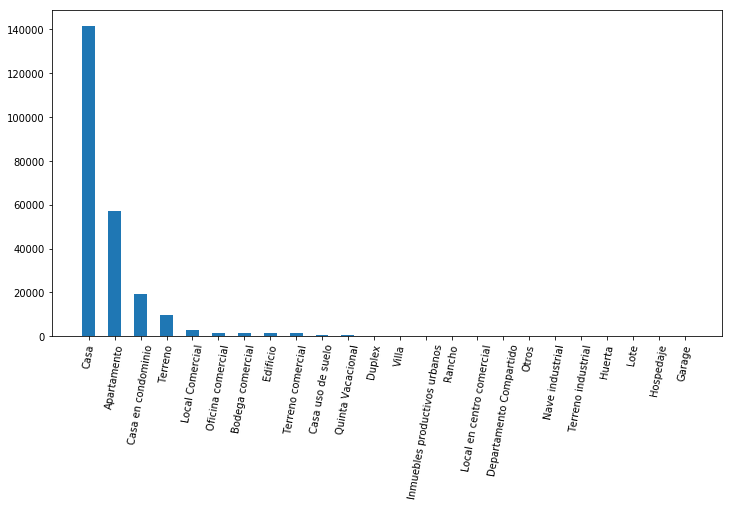

In [24]:
named_series_plot(df['tipodepropiedad'].value_counts(), xticks_rotation=80)

In [25]:
df['tipodepropiedad'].value_counts()

Casa                             141717
Apartamento                       57341
Casa en condominio                19297
Terreno                            9945
Local Comercial                    3055
Oficina comercial                  1741
Bodega comercial                   1406
Edificio                           1396
Terreno comercial                  1326
Casa uso de suelo                   708
Quinta Vacacional                   395
Duplex                              343
Villa                               340
Inmuebles productivos urbanos       200
Rancho                              170
Local en centro comercial           165
Departamento Compartido             141
Otros                               134
Nave industrial                      76
Terreno industrial                   31
Huerta                               20
Lote                                  5
Hospedaje                             1
Garage                                1
Name: tipodepropiedad, dtype: int64

In [26]:
list(df['tipodepropiedad'].value_counts().index)

['Casa',
 'Apartamento',
 'Casa en condominio',
 'Terreno',
 'Local Comercial',
 'Oficina comercial',
 'Bodega comercial',
 'Edificio',
 'Terreno comercial',
 'Casa uso de suelo',
 'Quinta Vacacional',
 'Duplex',
 'Villa',
 'Inmuebles productivos urbanos',
 'Rancho',
 'Local en centro comercial',
 'Departamento Compartido',
 'Otros',
 'Nave industrial',
 'Terreno industrial',
 'Huerta',
 'Lote',
 'Hospedaje',
 'Garage']

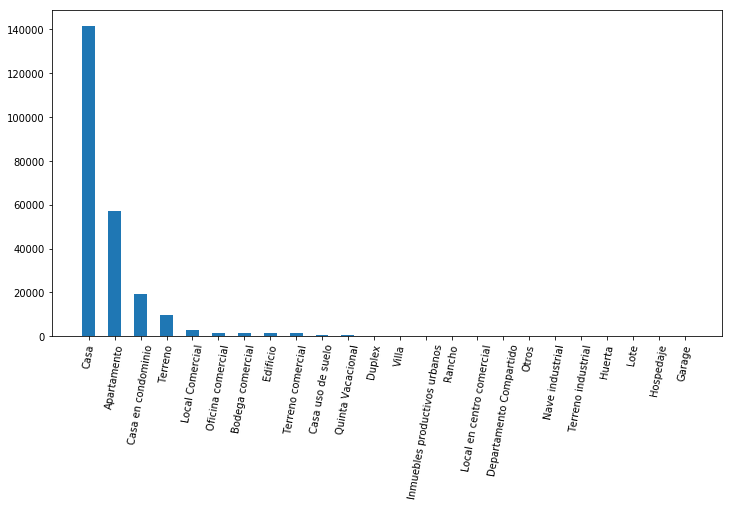

In [27]:
named_series_plot(df['tipodepropiedad'].value_counts(), xticks_rotation=80)

## Metros: totales y cubiertos

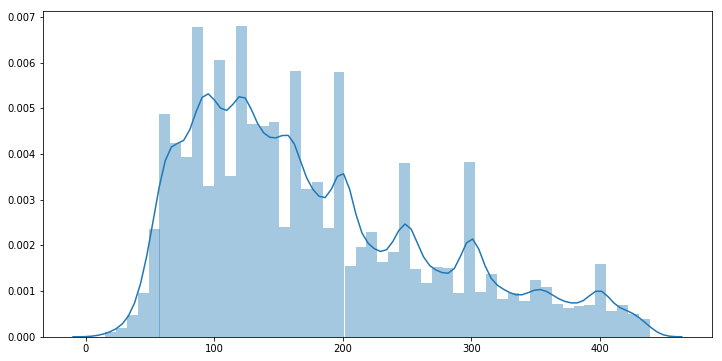

In [30]:
density_plot('metrostotales')

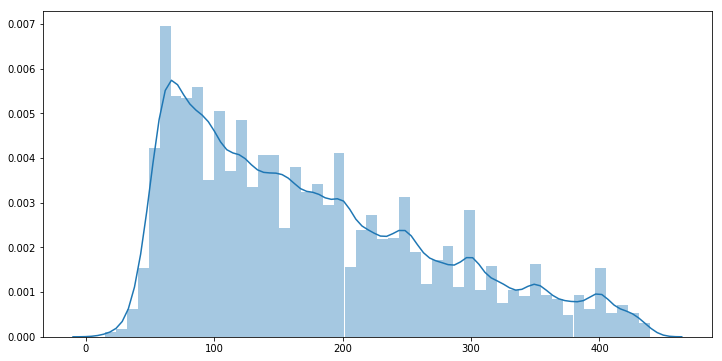

In [31]:
density_plot('metroscubiertos')

In [32]:
df['ratio_metros_totales_cubiertos'] = df['metroscubiertos']/df['metrostotales']

In [33]:
df.loc[df['ratio_metros_totales_cubiertos'] <= 1].shape

(100838, 25)

In [34]:
df.shape

(240000, 25)

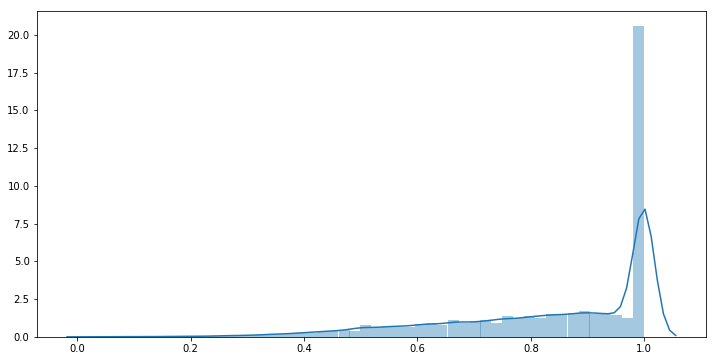

In [35]:
density_plot(df=df.loc[df['ratio_metros_totales_cubiertos'] <= 1], column='ratio_metros_totales_cubiertos')

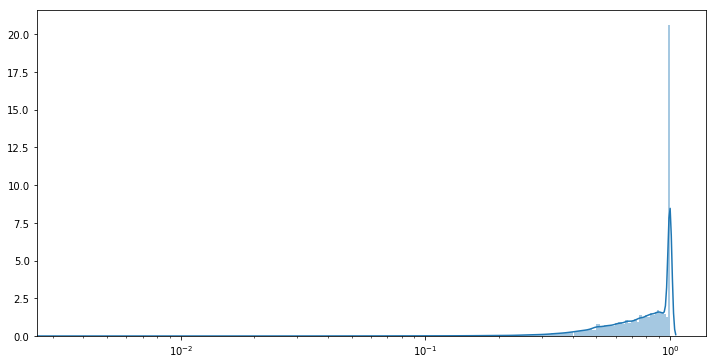

In [36]:
density_plot(df=df.loc[df['ratio_metros_totales_cubiertos'] <= 1], column='ratio_metros_totales_cubiertos', log=True)

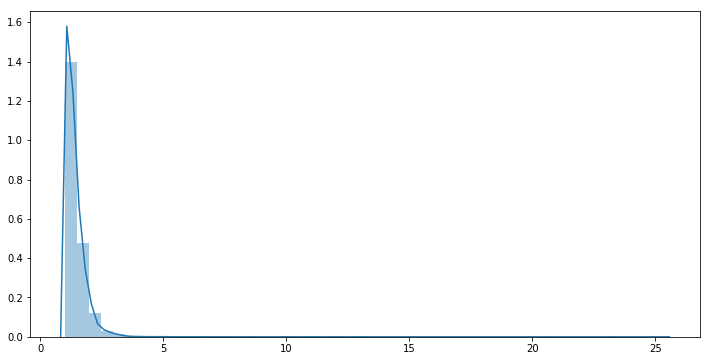

In [37]:
density_plot(df=df.loc[df['ratio_metros_totales_cubiertos'] > 1], column='ratio_metros_totales_cubiertos')

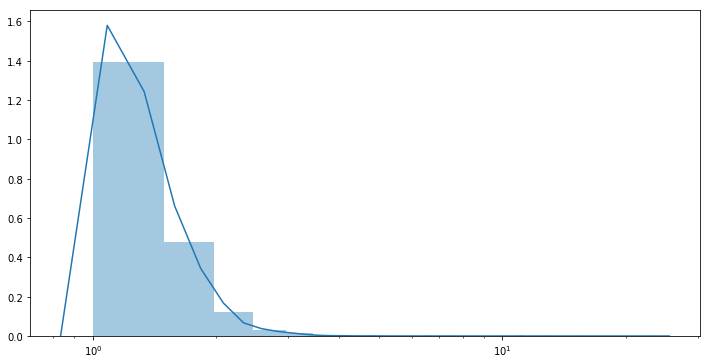

In [38]:
density_plot(df=df.loc[df['ratio_metros_totales_cubiertos'] > 1], column='ratio_metros_totales_cubiertos', log=True)

## Antiguedad

In [39]:
df['antiguedad'].nunique()

78

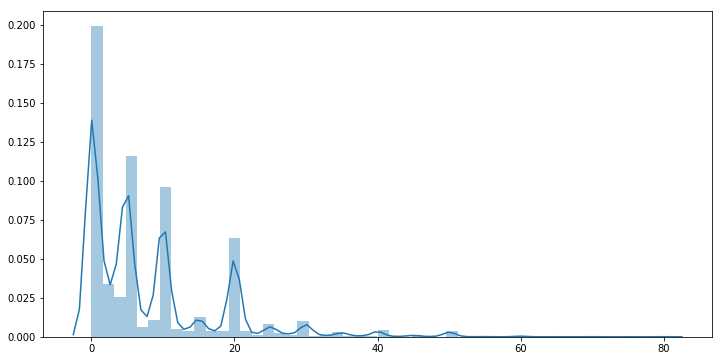

In [40]:
density_plot('antiguedad')

## Habitaciones

In [41]:
df['habitaciones'].value_counts()

3.0     121887
2.0      57808
4.0      25068
1.0       5069
5.0       4596
6.0       1669
7.0        539
8.0        398
10.0       316
9.0        179
Name: habitaciones, dtype: int64

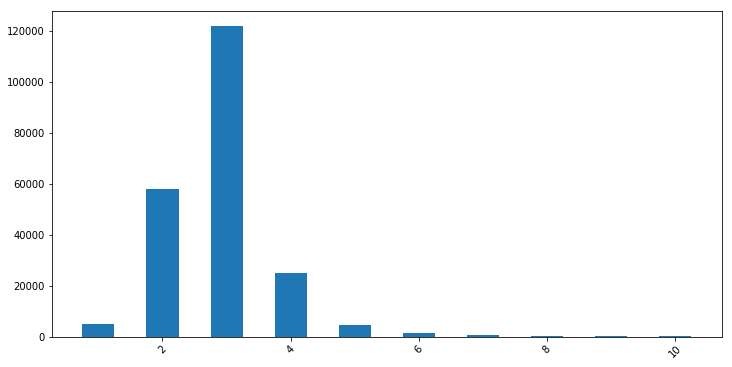

In [42]:
named_series_plot(df['habitaciones'].value_counts())

## Garages

In [43]:
df['garages'].value_counts()

2.0    94167
1.0    59464
0.0    26926
3.0    21678
Name: garages, dtype: int64

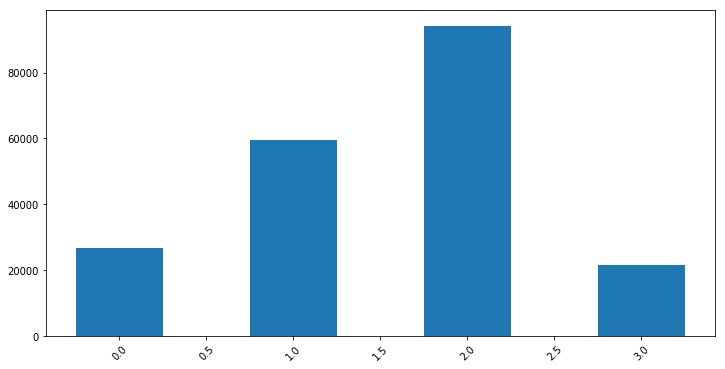

In [44]:
named_series_plot(df['garages'].value_counts())

## Banos

In [45]:
df['banos'].value_counts()

2.0    87683
1.0    58173
3.0    49365
4.0    18558
Name: banos, dtype: int64

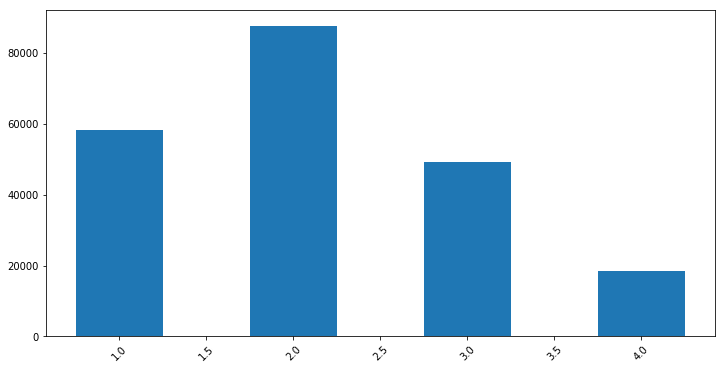

In [46]:
named_series_plot(df['banos'].value_counts())

In [47]:
df.columns

Index(['id', 'titulo', 'descripcion', 'tipodepropiedad', 'direccion', 'ciudad',
       'provincia', 'antiguedad', 'habitaciones', 'garages', 'banos',
       'metroscubiertos', 'metrostotales', 'idzona', 'lat', 'lng', 'fecha',
       'gimnasio', 'usosmultiples', 'piscina', 'escuelascercanas',
       'centroscomercialescercanos', 'precio', 'es_avenida',
       'ratio_metros_totales_cubiertos'],
      dtype='object')

In [52]:
df['fecha'].nunique()

1830

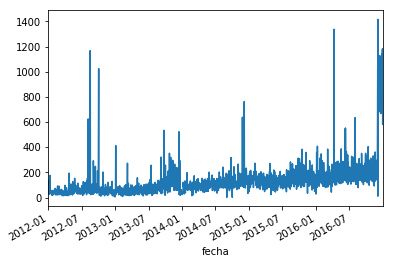

In [53]:
df.groupby('fecha')['id'].count().plot()

In [50]:
beep()